In [1]:
import pImpactR as impact
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as copy

In [2]:
nturn = 15

In [3]:
beam,lattice = impact.elegant2impact('NSLS2.lat',impact.util.Me,3.0e9,-1.0,min_sext_L=0.05)
beam.nCore_y = 8
beam.nCore_z = 4
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

lattice.insert(0,impact.getElem('loop'))
lattice[0].turns=nturn

write = impact.getElem('write_raw_ptcl')
write.file_id = 1111
write.format_id = 2
write.turn = nturn
lattice.append(write)

for elem in lattice:
    if 'length' in elem:
        elem.n_sckick = int(np.ceil(elem.length*10))
        elem.n_map = 1

elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.25 found. Converting to 5 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.2 found. Converting to 4 drift-kick-drift thin element
elegant ksext of length 0.2

# Prepare P

In [4]:
xmax = 0.045
ymax = 0.025
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pData = []
nx = 100
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(0,ymax,nx):
        if (x/xmax)**2+(y/ymax)**2<=1 :
            k+=1
            pData.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k])

pData = np.array(pData)
ke = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency
impact.writeParticleData(pData, ke, mass, freq)

npt = len(pData)
beam.n_particles = npt
print('initial npt=',npt)
pData = {'F0':pData}

initial npt= 7730


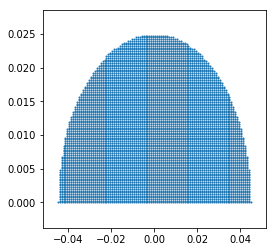

In [5]:
plt.figure(figsize=(4,4))
plt.scatter(pData['F0'][:,0],pData['F0'][:,2],s=1)

# Run Forward

In [6]:
impact.writeInputFile(beam,lattice)
impact.run(beam)

0

In [7]:
tmp = impact.readParticleData(1111,ke,mass,freq,2)
pData['F1']=tmp

# Run Backward

In [8]:
beam.distribution.distribution_type = 'ReadFile_binary'
beam.distribution.file_id = 1111

In [9]:
latticeB = copy(lattice[::-1])
latticeB.insert(0,copy(lattice[0]))
latticeB.pop()


  type: 'loop'
 turns: 15

In [10]:
latticeB.pop(1)


          type: 'write_raw_ptcl'
       file_id: 1111
     format_id: 2
          turn: 15
 sample_period: 1

In [11]:
latticeB[0].turns = nturn
latticeB.append(write)

for i in range(len(latticeB)):
    if 'length' in latticeB[i]:
        latticeB[i].length = -latticeB[i].length
        
    if latticeB[i].type == 'dipole':
        
        latticeB[i].bending_angle            =-latticeB[i].bending_angle
        latticeB[i].fringe_field_integration =-latticeB[i].fringe_field_integration
        
        exitAng  = latticeB[i].exit_angle
        enterAng = latticeB[i].entrance_angle
        latticeB[i].exit_angle     = -enterAng
        latticeB[i].entrance_angle = -exitAng
        
    if 'KL_sext' in latticeB[i]:
        latticeB[i].KL_sext = -latticeB[i].KL_sext


impact.writeInputFile(beam,latticeB)
impact.run(beam)

0

In [12]:
tmp = impact.readParticleData(1111,ke,mass,freq,2)
pData['B0']=tmp

# remove lost particles

In [13]:
iLive = pData['B0'][:,-1]
tmp = np.in1d(pData['F0'][:,-1],iLive)
pData['F0'] = pData['F0'][tmp,:]
tmp = np.in1d(pData['F1'][:,-1],iLive)
pData['F1'] = pData['F1'][tmp,:]

# plot

In [14]:
diff = 0
for i in range(4):
    tmp = (pData['F0'][:,i]-pData['B0'][:,i])**2
    print(np.mean(tmp),np.std(tmp))
    diff = diff + tmp
diff = np.sqrt(diff)

nan nan
nan nan
nan nan
nan nan


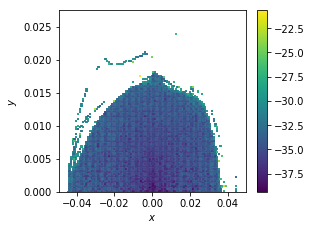

In [15]:
plt.figure(figsize=[4.4,3.3])
f1=plt.scatter(pData['F0'][:,0],pData['F0'][:,2],c=np.log(diff),s=1.6,marker='s')
plt.xlim(-xmax*1.1,xmax*1.1)
plt.ylim(0,ymax*1.1)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.colorbar(f1)
plt.tight_layout()